Name: Ali Aramideh

Student ID: 98101736

## Import needed libraries

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing Libraries
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Scikit-Learn for Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Transformers and PyTorch for Deep Learning
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from joblib import dump
from huggingface_hub import notebook_login

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Loading the data

In [ ]:
column_names = ['label', 'tweet_id', 'date', 'query', 'user_id', 'text']
df = pd.read_csv('./p2_data_orig.csv', header=None, names=column_names, encoding="ISO-8859-1")

In [ ]:
df.head()

,label,tweet_id,date,user_id,text
0,0,1467810369,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df['label'].value_counts()

label
0    800000
4    800000
Name: count, dtype: int64

In [ ]:
df.drop(['query'], axis = 1, inplace = True)

df.drop_duplicates(subset=['tweet_id'], inplace=True)

df['label'] = df['label'].apply(lambda x: 0 if x == 0 else 1)

df['date'] = pd.to_datetime(df['date'])

df.info()

C:\Users\Dan\AppData\Local\Temp\ipykernel_1956\1462158230.py:7: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['date'] = pd.to_datetime(df['date'])


<class 'pandas.core.frame.DataFrame'>
Index: 1598315 entries, 0 to 1599999
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   label     1598315 non-null  int64         
 1   tweet_id  1598315 non-null  int64         
 2   date      1598315 non-null  datetime64[ns]
 3   user_id   1598315 non-null  object        
 4   text      1598315 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 73.2+ MB


Before proceeding with text cleaning, it's important to note that our dataset is exceptionally large, and training a model on it can be time-consuming. To address this, we will randomly select a portion of this data to serve as our primary dataset. This decision is facilitated by the fact that our dataset's labels are evenly balanced, so there's no concern about creating an unbalanced sample.

In [ ]:
df_sampled = df.sample(n=100000, random_state=42)
df_sampled['label'].value_counts()

label
1    50109
0    49891
Name: count, dtype: int64

In [ ]:
def clean_text(input_text):
    # Convert input_text to lowercase
    cleaned_text = input_text.lower()
    
    # Remove special characters (keep letters and digits)
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', cleaned_text)
    
    # Tokenize text
    text_tokens = word_tokenize(cleaned_text)
    
    # Remove stopwords (optional, based on your need)
    stop_words = set(stopwords.words('english'))
    text_tokens = [word for word in text_tokens if word not in stop_words]
    
    # Initialize stemmer and lemmatizer
    porter_stemmer = PorterStemmer()
    word_lemmatizer = WordNetLemmatizer()
    
    # Apply stemming and lemmatization (you might choose one based on your need)
    stemmed_tokens = [porter_stemmer.stem(word) for word in text_tokens]
    lemmatized_tokens = [word_lemmatizer.lemmatize(word) for word in text_tokens]
    
    # Join tokens back to form the cleaned text
    cleaned_text = ' '.join(lemmatized_tokens)  # or use stemmed_tokens if preferred
    
    return cleaned_text

# Apply the clean_text function to the 'text' column of your DataFrame
df_sampled['cleaned_text'] = df_sampled['text'].apply(clean_text)

# Display the cleaned DataFrame
df_sampled.head()

,label,tweet_id,date,user_id,text
128328,0,1834889650,2009-05-18 04:31:31,mcoopers81,wish got leather httptwitpiccom5f6f5
1452143,1,2063109108,2009-06-07 01:24:11,unmediated,nice bit dog macbeth julius c tempest broadcas...
579965,0,2213701371,2009-06-17 15:43:43,missinfo,httptwitpiccom7nt1z tiffthestylist buttiffi love
1396062,1,2053793237,2009-06-06 05:43:04,schel,warrencheetham back hows going
1359654,1,2048513310,2009-06-05 15:19:20,xmissmcflyx,mcflymagazine could u help gt folk follow tht ...


Now we will save this dataset and use this for further edo.

In [ ]:
df_sampled.reset_index(inplace=True, drop=True)
df_sampled.to_csv("./cleaned_p2.csv")

## Applying different models

In [2]:
# loading the saved data
df_sampled = pd.read_csv("./cleaned_p2.csv")
df_sampled['text'] = df_sampled['text'].fillna("")

# splitting data into train, eval and test
X = df_sampled['text']  # Features
y = df_sampled['label']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_eval, X_test, y_eval, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### BOW

training the model

In [ ]:
# Create a pipeline that first creates bag of words features, then trains a logistic regression model
bow_pipeline = make_pipeline(
    CountVectorizer(),
    LogisticRegression(max_iter=1000)
)

bow_pipeline.fit(X_train.values, y_train.values)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

evaluating the model

In [ ]:
# Predictions on train, eval, and test sets
y_train_pred = bow_pipeline.predict(X_train.values)
y_eval_pred = bow_pipeline.predict(X_eval.values)
y_test_pred = bow_pipeline.predict(X_test.values)

# Calculate and print accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
eval_accuracy = accuracy_score(y_eval, y_eval_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {eval_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

# Classification Report
print("\nClassification Report for Training Set:")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report for Evaluation Set:")
print(classification_report(y_eval, y_eval_pred))

print("\nClassification Report for Testing Set:")
print(classification_report(y_test, y_test_pred))

Training Accuracy: 0.8937625
Testing Accuracy: 0.7669
Validation Accuracy: 0.7604

Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     39859
           1       0.89      0.90      0.89     40141

    accuracy                           0.89     80000
   macro avg       0.89      0.89      0.89     80000
weighted avg       0.89      0.89      0.89     80000


Classification Report for Testing Set:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      4970
           1       0.76      0.79      0.77      5030

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000


Classification Report for Evaluation Set:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76      5062
           1       0.75      0.

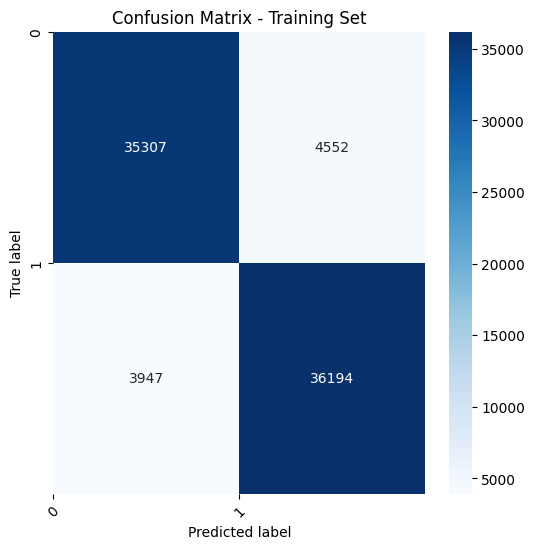

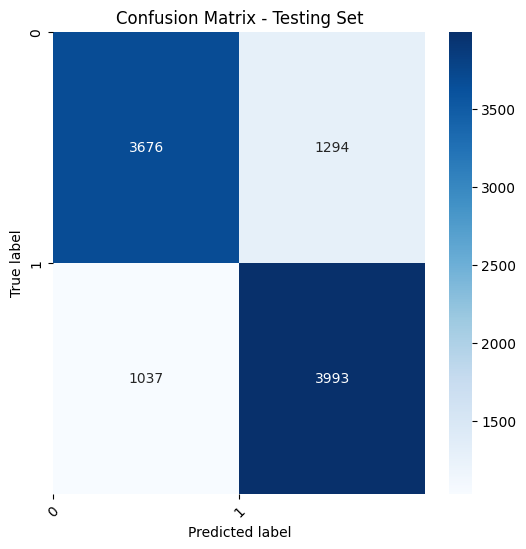

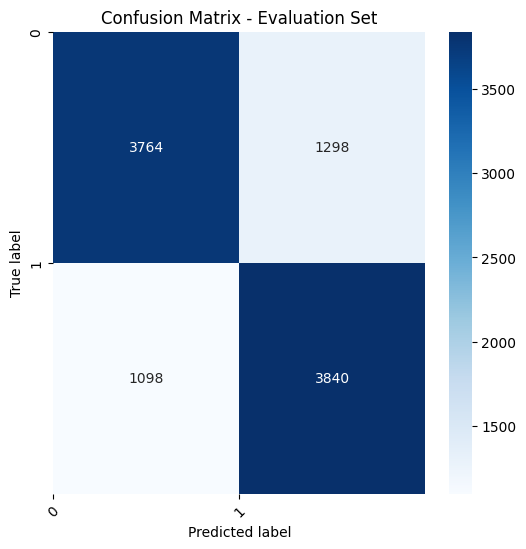

In [ ]:
# Helper function to plot confusion matrix
def plot_confusion_matrix(confusion_matrix, class_labels, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap=cmap)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
    plt.yticks(np.arange(len(class_labels)), class_labels)
    plt.show()

# Calculate confusion matrices
confusion_matrix_train = confusion_matrix(y_train.values, y_train_pred)
confusion_matrix_eval = confusion_matrix(y_eval.values, y_eval_pred)
confusion_matrix_test = confusion_matrix(y_test.values, y_test_pred)

# Plot confusion matrices
plot_confusion_matrix(confusion_matrix_train, class_labels=bow_pipeline.classes_, title='Confusion Matrix - Training Set')
plot_confusion_matrix(confusion_matrix_eval, class_labels=bow_pipeline.classes_, title='Confusion Matrix - Evaluation Set')
plot_confusion_matrix(confusion_matrix_test, class_labels=bow_pipeline.classes_, title='Confusion Matrix - Testing Set')

Saving model

In [ ]:
dump(bow_pipeline, "bow_model.joblib")

['bow_model.joblib']

### TF-IDF

training the model

In [ ]:
# Create a pipeline that first creates TF-IDF features, then trains a logistic regression model
tfidf_pipeline = make_pipeline(
    TfidfVectorizer(),
    LogisticRegression(max_iter=1000)
)

# Train the model
tfidf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

evaluating the model

Training Accuracy: 0.8407
Testing Accuracy: 0.7701
Evaluation Accuracy: 0.7679

Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84     39859
           1       0.83      0.86      0.84     40141

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000


Classification Report for Testing Set:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      4970
           1       0.76      0.79      0.78      5030

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000


Classification Report for Evaluation Set:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      5062
           1       0.76      0.78 

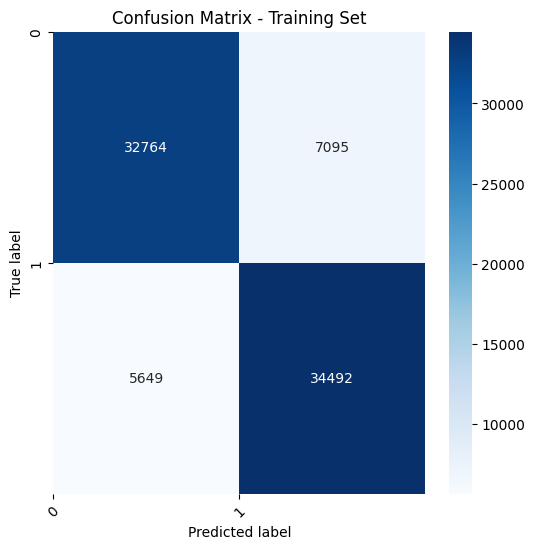

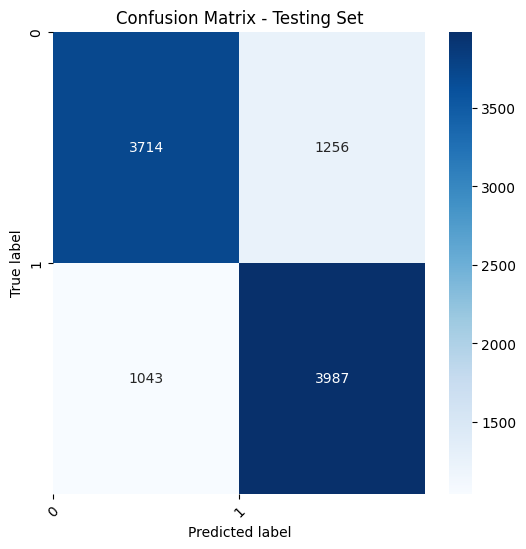

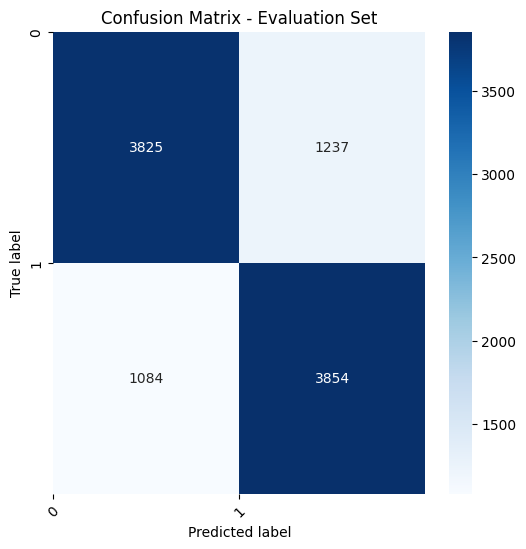

In [ ]:
y_train_pred = tfidf_pipeline.predict(X_train)
y_test_pred = tfidf_pipeline.predict(X_test)
y_eval_pred = tfidf_pipeline.predict(X_eval)

# Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
eval_accuracy = accuracy_score(y_eval, y_eval_pred)
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")
print(f"Evaluation Accuracy: {eval_accuracy}")

# Classification Report
print("\nClassification Report for Training Set:")
print(classification_report(y_train, y_train_pred))
print("\nClassification Report for Testing Set:")
print(classification_report(y_test, y_test_pred))
print("\nClassification Report for Evaluation Set:")
print(classification_report(y_eval, y_eval_pred))

# Confusion Matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
cm_eval = confusion_matrix(y_eval, y_eval_pred)

plot_confusion_matrix(cm_train, classes=tfidf_pipeline.classes_, title='Confusion Matrix - Training Set')
plot_confusion_matrix(cm_test, classes=tfidf_pipeline.classes_, title='Confusion Matrix - Testing Set')
plot_confusion_matrix(cm_eval, classes=tfidf_pipeline.classes_, title='Confusion Matrix - Evaluation Set')

Saving the model

In [ ]:
dump(tfidf_pipeline, "tfidf_model.joblib")

['tfidf_model.joblib']

### BERT

Tokenization and DataLoader Preparation

In [ ]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize texts
def tokenize_texts(texts):
    """
    Tokenizes texts to prepare for BERT model input.
    
    Parameters:
    - texts: A list of strings, each representing a text document.
    
    Returns:
    - A dictionary containing tokenized outputs suitable for model input.
    """
    # Tokenize all texts with specified parameters
    tokenized_batch = tokenizer.batch_encode_plus(
        texts,
        max_length=128,  # Ensures all sequences are at most 128 tokens long
        padding='max_length',  # Pads shorter sequences to the max length
        truncation=True,  # Truncates longer sequences to the max length
        return_tensors='pt'  # Returns PyTorch tensors
    )
    return tokenized_batch

# Function to create a dataset from input features and labels
def create_dataset(X, y):
    """
    Creates a PyTorch dataset from input features and labels.
    
    Parameters:
    - X: Input features, a list of text documents.
    - y: Corresponding labels for the input features.
    
    Returns:
    - A TensorDataset containing input_ids, attention_mask, and labels.
    """
    inputs = tokenize_texts(X.tolist())
    labels = torch.tensor(y.tolist())
    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
    return dataset

# Preparing datasets
train_dataset = create_dataset(X_train, y_train)
test_dataset = create_dataset(X_test, y_test)
eval_dataset = create_dataset(X_eval, y_eval)

# Setting up DataLoaders with specified batch size
batch_size = 16
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)
eval_dataloader = DataLoader(eval_dataset, sampler=SequentialSampler(eval_dataset), batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Model Training

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y_train)))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Initialization of the optimizer with the model's parameters
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Setting the number of training epochs
epochs = 3

# Calculating the total number of training steps
total_steps = len(train_dataloader) * epochs

# Scheduler for learning rate adjustment
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,  # No initial warmup
    num_training_steps=total_steps  # Based on the total number of steps
)

# Function for accuracy calculation
def flat_accuracy(preds, labels):
    """Computes the accuracy of predictions against labels."""
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Model set to training mode
model.train()

# Training loop
for epoch_i in range(epochs):
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    total_loss = 0
    train_acc = 0
    train_steps = 0

    # Progress bar
    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))

    for step, batch in pbar:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        # Clear gradients
        model.zero_grad()

        # Forward pass and compute loss
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Accumulate accuracy
        tmp_train_accuracy = flat_accuracy(logits, label_ids)
        train_acc += tmp_train_accuracy
        train_steps += 1

        # Backward pass and optimization
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # Progress bar update
        pbar.set_description(f"Epoch {epoch_i + 1} Step {step + 1}/{len(train_dataloader)} Loss: {loss.item():.4f}")

    # Epoch-wise average loss and accuracy
    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_acc = train_acc / train_steps
    print(f"Average training loss: {avg_train_loss:.2f}")
    print(f"Training accuracy: {avg_train_acc:.2f}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


======== Epoch 1 / 3 ========


Epoch 1 Step 5000/5000 Loss: 0.7310: 100%|██████████| 5000/5000 [28:34<00:00,  2.92it/s]


Average training loss: 0.48
======== Epoch 2 / 3 ========


Epoch 2 Step 5000/5000 Loss: 0.5976: 100%|██████████| 5000/5000 [28:46<00:00,  2.90it/s]


Average training loss: 0.37
======== Epoch 3 / 3 ========


Epoch 3 Step 5000/5000 Loss: 0.3891: 100%|██████████| 5000/5000 [28:41<00:00,  2.90it/s]

Average training loss: 0.27
Training accuracy: 0.89


Model Evaluation

In [ ]:
# Set the model to evaluation mode to disable dropout layers
model.eval()

# Initialize variables to track evaluation loss and accuracy
eval_accuracy = 0
nb_eval_steps = 0

# Iterate over the evaluation data loader
for batch in eval_dataloader:
    # Move batch to the appropriate device
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # Disable gradient calculations to save memory and computations
    with torch.no_grad():
        # Perform a forward pass (evaluate the model on this batch)
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits to CPU and convert to numpy arrays for accuracy calculation
    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate and accumulate the batch's accuracy
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

# Compute the overall evaluation accuracy
overall_eval_accuracy = eval_accuracy / nb_eval_steps
print(f"Evaluation accuracy: {overall_eval_accuracy:.2f}")


Evaluation accuracy: 0.80


In [ ]:
model.eval()  # Set model to evaluation mode

test_loss, test_accuracy = 0, 0
nb_test_steps, nb_test_examples = 0, 0

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_test_accuracy = flat_accuracy(logits, label_ids)
    test_accuracy += tmp_test_accuracy
    nb_test_steps += 1

print("Test accuracy: {0:.2f}".format(test_accuracy/nb_test_steps))

Test accuracy: 0.80


Now we will save the model for further use.

In [ ]:
model.save_pretrained("./bert_model")

Zipping the folder to download it

In [ ]:
import os
import zipfile

def zip_folder(folder_path, output_zip_file):
    with zipfile.ZipFile(output_zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, os.path.dirname(folder_path))
                zipf.write(file_path, arcname=arcname)

folder_path = '/content/bert_model'
output_zip_file = '/content/bert.zip'
zip_folder(folder_path, output_zip_file)

### ROBERTA

Using some of the previous code

In [3]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

First we must login to our hugging-face account

In [4]:
hugging_face_id="Dan1212121212"
# read permission
notebook_login()

In [5]:
# write permission
notebook_login()

Now we will load the base model from HF. Note that when we use the login command the model will be automatically loaded from hugging face. We will then save the model to hugging face.

In [6]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(set(y)))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now we create the data loaders

In [7]:
def encode_data(tokenizer, texts, labels, max_length=128):
    """
    Encodes textual data into a format suitable for model training or evaluation.

    Parameters:
    - tokenizer: The tokenizer to be used for encoding the texts.
    - texts: A list of texts to be encoded.
    - labels: The labels corresponding to the texts.
    - max_length: Maximum length of the encoded sequences.

    Returns:
    - A TensorDataset containing encoded inputs and labels.
    """
    # Encode the texts using the provided tokenizer
    encodings = tokenizer.batch_encode_plus(
        texts, 
        max_length=max_length, 
        truncation=True, 
        padding='max_length', 
        return_tensors='pt'
    )
    # Create a TensorDataset with input_ids, attention_mask, and labels
    dataset = TensorDataset(
        encodings['input_ids'], 
        encodings['attention_mask'], 
        torch.tensor(labels)
    )
    return dataset

# Tokenize and encode datasets
train_dataset = encode_data(tokenizer, X_train.tolist(), y_train.tolist())
eval_dataset = encode_data(tokenizer, X_eval.tolist(), y_eval.tolist())
test_dataset = encode_data(tokenizer, X_test.tolist(), y_test.tolist())

# Specify the batch size for dataloaders
batch_size = 16

# Initialize dataloaders for each dataset with appropriate samplers
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
eval_dataloader = DataLoader(eval_dataset, sampler=RandomSampler(eval_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

Training the model

In [8]:
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

for epoch_i in range(epochs):
    model.train()
    total_loss = 0
    train_acc, train_steps = 0, 0

    for step, batch in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch_i+1}')):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_attention_mask, b_labels = batch
        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_train_accuracy = flat_accuracy(logits, label_ids)
        train_acc += tmp_train_accuracy
        train_steps += 1

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss}")
    print("Training accuracy: {0:.2f}".format(train_acc/train_steps))

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 5000/5000 [31:09<00:00,  2.67it/s]


Average training loss: 0.5902558310270309
Training accuracy: 0.71


Epoch 2: 100%|██████████| 5000/5000 [31:13<00:00,  2.67it/s]


Average training loss: 0.5506587873369455
Training accuracy: 0.75


Epoch 3: 100%|██████████| 5000/5000 [31:12<00:00,  2.67it/s]

Average training loss: 0.49094601691961287
Training accuracy: 0.78


Evaluating model

In [9]:
model.eval()  # Set model to evaluation mode

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

for batch in eval_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("Evaluation accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))

Evaluation accuracy: 0.78


In [10]:
model.eval()

# Initialize variables to track test loss and accuracy.
test_accuracy = 0.0
nb_test_steps = 0

# Iterate over batches in the test dataset.
for batch in test_dataloader:
    # Move batch to the appropriate device (CPU or GPU).
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # Disable gradient computation to save memory and improve speed.
    with torch.no_grad():
        # Perform a forward pass (model inference) to compute logits.
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Detach the logits from the graph and move them to CPU, then convert to NumPy arrays.
    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Compute the accuracy of this batch and accumulate it over all batches.
    tmp_test_accuracy = flat_accuracy(logits, label_ids)
    test_accuracy += tmp_test_accuracy
    nb_test_steps += 1

# Calculate and print the overall test accuracy.
overall_test_accuracy = test_accuracy / nb_test_steps
print(f"Test accuracy: {overall_test_accuracy:.2f}")


Test accuracy: 0.78


Saving the model

In [11]:
model.save_pretrained("./roberta_model")
model.save_pretrained(f"{hugging_face_id}/roberta_DS", push_to_hub=True)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Zipping it for download

In [12]:
import os
import zipfile

def zip_folder(folder_path, output_zip_file):
    with zipfile.ZipFile(output_zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, os.path.dirname(folder_path))
                zipf.write(file_path, arcname=arcname)

folder_path = '/content/roberta_model'
output_zip_file = '/content/roberta.zip'
zip_folder(folder_path, output_zip_file)

## Comparing them together

Analyzing the accuracy results of all the models, we observe that the top-performing model is BERT, followed closely by the ROBERTA model. This outcome aligns with our expectations, as these models are more complex and powerful. Additionally, we notice that the TF-IDF and Bag of Words (BOW) models exhibit nearly identical performance.